In [1]:
# %load fasion_mnist迁移学习.py
import numpy as np
from keras.datasets import fashion_mnist
import gc

from keras.models import Sequential, Model
from keras.layers import Input, Dense, Dropout, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.applications.vgg16 import VGG16
from keras.optimizers import SGD
import matplotlib.pyplot as plt
import os

import cv2
import h5py as h5py 
import numpy as np
def tran_y(y): 
    y_ohe = np.zeros(10) 
    y_ohe[y] = 1 
    return y_ohe
epochs = 10

# 如果硬件配置较高，比如主机具备32GB以上内存，GPU具备8GB以上显存，可以适当增大这个值。VGG要求至少48像素
ishape=48
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data() 

X_train = [cv2.cvtColor(cv2.resize(i, (ishape, ishape)), cv2.COLOR_GRAY2BGR) for i in X_train] 
X_train = np.concatenate([arr[np.newaxis] for arr in X_train]).astype('float32') 
X_train /= 255.0

X_test = [cv2.cvtColor(cv2.resize(i, (ishape, ishape)), cv2.COLOR_GRAY2BGR) for i in X_test] 
X_test = np.concatenate([arr[np.newaxis] for arr in X_test]).astype('float32')
X_test /= 255.0

y_train_ohe = np.array([tran_y(y_train[i]) for i in range(len(y_train))]) 
y_test_ohe = np.array([tran_y(y_test[i]) for i in range(len(y_test))])
y_train_ohe = y_train_ohe.astype('float32')
y_test_ohe = y_test_ohe.astype('float32')


model_vgg = VGG16(include_top = False, weights = 'imagenet', input_shape = (ishape, ishape, 3)) 
for layer in model_vgg.layers:
        layer.trainable = False
model = Flatten()(model_vgg.output) 
model = Dense(4096, activation='relu', name='fc1')(model)
model = Dense(4096, activation='relu', name='fc2')(model)
model = Dropout(0.5)(model)
model = Dense(10, activation = 'softmax', name='prediction')(model) 
model_vgg_mnist_pretrain = Model(model_vgg.input, model, name = 'vgg16_pretrain')
model_vgg_mnist_pretrain.summary()
sgd = SGD(lr = 0.05, decay = 1e-5) 
model_vgg_mnist_pretrain.compile(loss = 'categorical_crossentropy', optimizer = sgd, metrics = ['accuracy'])
log  = model_vgg_mnist_pretrain.fit(X_train, y_train_ohe, validation_data = (X_test, y_test_ohe), epochs = epochs, batch_size = 64)

score = model_vgg_mnist_pretrain.evaluate(X_test, y_test_ohe, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])



/home/ian/installed/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 48, 48, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 48, 48, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 48, 48, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 24, 24, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 24, 24, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 24, 24, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 12, 12, 128)       0         
__________

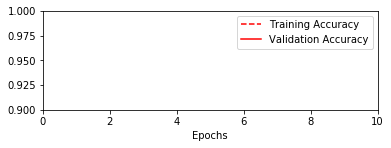

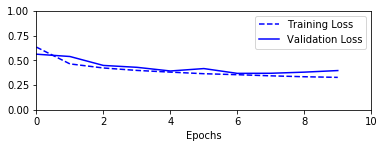

In [2]:
plt.figure('acc')  
plt.subplot(2, 1, 1)  
plt.plot(log.history['acc'],'r--',label='Training Accuracy')  
plt.plot(log.history['val_acc'],'r-',label='Validation Accuracy')  
plt.legend(loc='best')  
plt.xlabel('Epochs')  
plt.axis([0, epochs, 0.9, 1])  
plt.figure('loss')  
plt.subplot(2, 1, 2)  
plt.plot(log.history['loss'],'b--',label='Training Loss')  
plt.plot(log.history['val_loss'],'b-',label='Validation Loss')  
plt.legend(loc='best')  
plt.xlabel('Epochs')  
plt.axis([0, epochs, 0, 1])  
  
plt.show() 